In [1]:
import sys
# sys.path.append('../../')

from os import listdir

from hdf5storage import loadmat, savemat 
import numpy as np 
from matplotlib import pyplot as plt

from scipy import signal 
# from hnlpy.timeop import makefiltersos
# from hnlpy.timeop import narrowfilter 
from scipy.signal import sosfiltfilt
from scipy.signal import hilbert
from scipy.signal import savgol_filter
from scipy.stats import sem
from scipy import stats
from scipy.stats import f_oneway
from numpy.polynomial.polynomial import polyfit, polyval

import networkx as nx


In [2]:
# (Color Scheme) 
red         = [1, 0, 0]
pink        = [1, 0.65, 0.75]
black       = [0, 0, 0]
white       = [1, 1, 1]
blue        = [0, 0, 1]
mediumblue  = [0, 0.4, 0.7]
green       = [0, 1, 0]
darkgreen   = [0, 0.5, 0]
grey        = [0.5, 0.5, 0.5]
yellow      = [1, 1, 0]
deepyellow  = [1, 0.8, 0.2]
gold        = [212/255, 175/255, 55/255]
brown       = [150/255, 75/255, 0]
magenta     = [1, 0, 1] 
cyan        = [0, 1, 1]  
purple      = [0.6, 0.1, 0.9]

# % https://www.mathworks.com/help/matlab/creating_plots/specify-plot-colors.html
matlab_blue     = [0, 0.4470, 0.7410]
matlab_orange   = [0.8500, 0.3250, 0.0980]
matlab_gold     = [0.9290, 0.6940, 0.1250]
matlab_purple   = [0.4940, 0.1840, 0.5560]
matlab_green    = [0.4660, 0.6740, 0.1880]
matlab_cyan     = [0.3010, 0.7450, 0.9330]
matlab_red      = [0.6350, 0.0780, 0.1840]

# combine colors
condicolors = [darkgreen, red, blue, magenta, purple, purple]
dire3colors = [darkgreen, brown, magenta]
syn2colors = [darkgreen, pink]
HNLcolors = [darkgreen, deepyellow, pink]

color_4st=['green','red','blue','black']

In [9]:
# load chan locs for topoplots
dict_loc=loadmat('../Pcorr_4states_2sestype/chan_locs/xyzlabels.mat')
x=dict_loc['x']
y=dict_loc['y']
z=dict_loc['z']
labels=dict_loc['labels']

# adjust coords for nilearn plots
coords=np.zeros((32,3))
for i in range(32):
    coords[i,:]=[x[i]*700, y[i]*900-15, z[i]*950-15]

#  construct text for networkx labels
labeldict = {}
for i in range(32):
    labeldict[i]=labels[i]

# load pos for networkx plots
pos_mat=loadmat('../Pcorr_4states_2sestype/chan_locs/pos.mat')
pos=pos_mat['pos']


# construct full edges_list
edges_list=list() # each edge is a two element tuple
for i in range(32):
    for j in range(32):
        if i<j: # use indicies to remove half of edges and colors and the diagonal
            edges_list.append((i,j))

In [15]:
# variable names for plotting
states4names=['Uncoupled','Leading','Following','Mutual']
syn2names=['Synch','Synco']
states3names=['Independent','Unidirectional','Bidirectional']
band_labels = ['Delta','Theta','Alpha','Mu','Beta1','Beta2','Gamma']

In [4]:
outdict=loadmat('Indicies.mat')

# condi4_ind          = outdict['condi4_ind']
# syn_ind             = outdict['syn_ind']
syn2_condi4_ind     = outdict['syn2_condi4_ind']

In [5]:
outdict=loadmat('Corr_eeg144.mat')

eeg_empirical_correlation144x2  = outdict['eeg_empirical_correlation144x2']     
eeg_partial_correlation144x2    = outdict['eeg_partial_correlation144x2']       
intervals144                    = outdict['intervals144']                       
samples144                      = outdict['samples144']                         
session144                      = outdict['session144']                         

In [6]:
# reorganzied into 496 edges for networkx computation in individual graph
eeg_pcorr_edges144x2x7x496 = np.zeros((144,2,7,496))
for n in range(144):
    for subj in range(2):
        for freq in range(7):
            e=0
            for i in range(32):
                for j in range(32):
                    if i<j: # use indicies to remove half of edges and colors and the diagonal
                        eeg_pcorr_edges144x2x7x496[n,subj,freq,e]=(eeg_partial_correlation144x2[n,subj,freq,i,j])
                        e+=1

In [10]:
# compute networkx properties degree centrality
eeg_pcorr_dgctr=np.zeros((144,2,7,32)) # degree centrality (does not account for weight)
for n in range(144):
    for subj in range(2):
        for freq in range(7):
            weights=eeg_pcorr_edges144x2x7x496[n,subj,freq,:].astype(bool)
            non0_edges=list()
            for i in range(len(edges_list)): # 496
                    if weights[i] != 0:
                            non0_edges.append(edges_list[i]+({'weight': weights[i]},))
            # networkx initiate with edges
            X = nx.Graph()
            X.add_nodes_from(range(32))
            X.add_edges_from(non0_edges)
            centrality_dict=nx.degree_centrality(X)
            contrality_value=np.array(list(centrality_dict.values()))
            eeg_pcorr_dgctr[n,subj,freq,:]=contrality_value


In [11]:
def cal_mean_sem_all_chan(mat1,mat2):
    # this function compute the mean and se for each chan
    trl_ctr=np.concatenate((mat1,mat2),axis=0)
    mean_trl_ctr=np.mean(trl_ctr,axis=0)
    sem_trl_ctr=sem(trl_ctr)
    return mean_trl_ctr, sem_trl_ctr

In [12]:
# organze eeg_pcorr_dgctr into 2x4x7x32 # ((144,2,7,32)) # degree centrality (does not account for weight)

# mean and sem of degree centralities in 32 channels  
eeg_pcorr_dgctr # 144x2x7x32
eeg_pcorr_dgctr_mean2x4x7x32=np.zeros((2,4,7,32)) # 2 syn types x 4 condi x 7 freq x 32 chan
eeg_pcorr_dgctr_sem2x4x7x32=np.zeros((2,4,7,32)) # 2 syn types x 4 condi x 7 freq x 32 chan

for syn in range(2):
    for freq in range(7):
        # Uncoupled
        mat1=eeg_pcorr_dgctr[syn2_condi4_ind[syn][0],0,freq,:]
        mat2=eeg_pcorr_dgctr[syn2_condi4_ind[syn][0],1,freq,:]
        eeg_pcorr_dgctr_mean2x4x7x32[syn,0,freq,:],eeg_pcorr_dgctr_sem2x4x7x32[syn,0,freq,:]=cal_mean_sem_all_chan(mat1,mat2)


        # Leading for L&R
        mat1=eeg_pcorr_dgctr[syn2_condi4_ind[syn][1],0,freq,:]
        mat2=eeg_pcorr_dgctr[syn2_condi4_ind[syn][2],1,freq,:]
        eeg_pcorr_dgctr_mean2x4x7x32[syn,1,freq,:],eeg_pcorr_dgctr_sem2x4x7x32[syn,1,freq,:]=cal_mean_sem_all_chan(mat1,mat2)

        # Following for L&R
        mat1=eeg_pcorr_dgctr[syn2_condi4_ind[syn][1],1,freq,:]
        mat2=eeg_pcorr_dgctr[syn2_condi4_ind[syn][2],0,freq,:]
        eeg_pcorr_dgctr_mean2x4x7x32[syn,2,freq,:],eeg_pcorr_dgctr_sem2x4x7x32[syn,2,freq,:]=cal_mean_sem_all_chan(mat1,mat2)

        # Mutual
        mat1=eeg_pcorr_dgctr[syn2_condi4_ind[syn][3],0,freq,:]
        mat2=eeg_pcorr_dgctr[syn2_condi4_ind[syn][3],1,freq,:]
        eeg_pcorr_dgctr_mean2x4x7x32[syn,3,freq,:],eeg_pcorr_dgctr_sem2x4x7x32[syn,3,freq,:]=cal_mean_sem_all_chan(mat1,mat2)


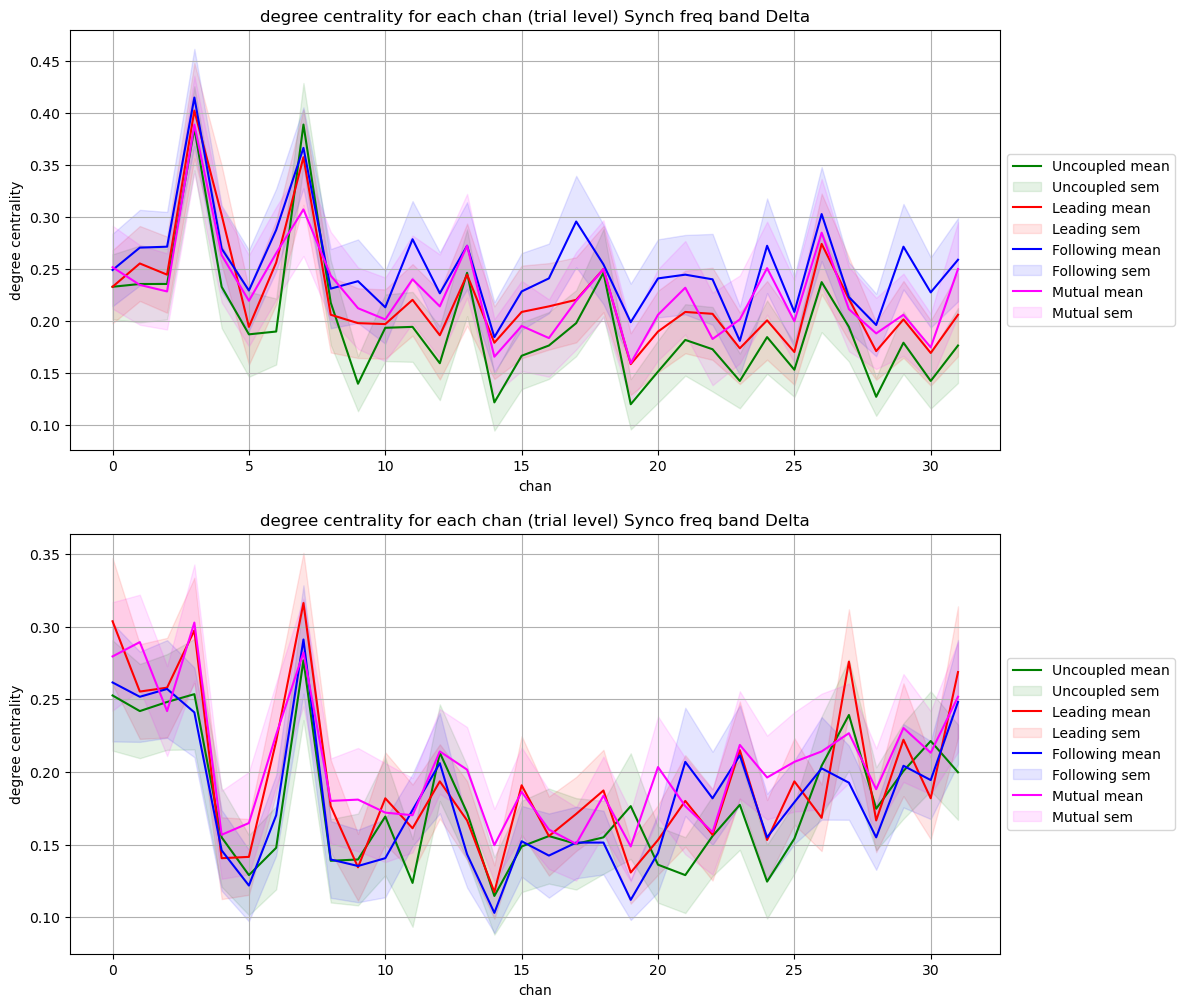

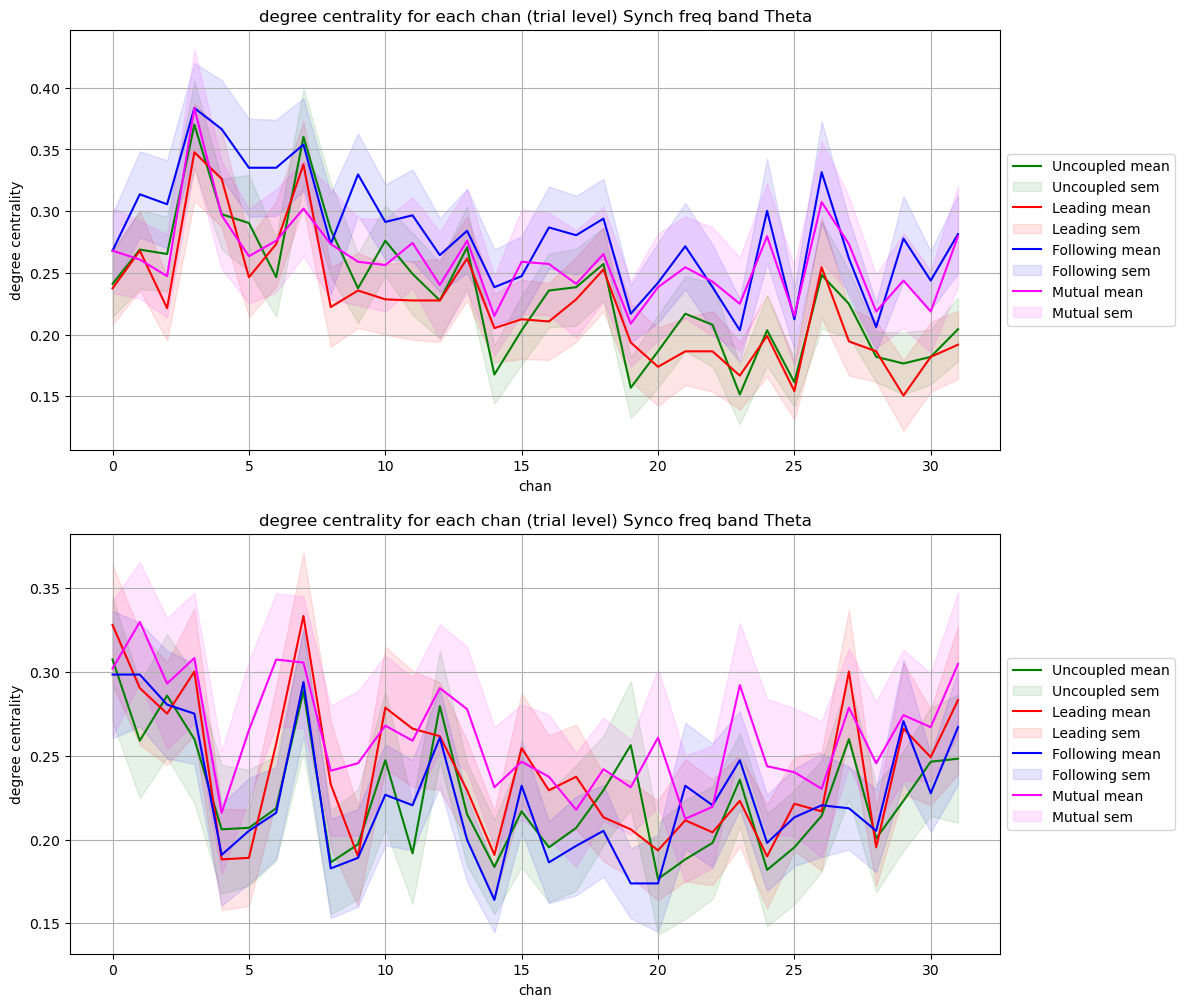

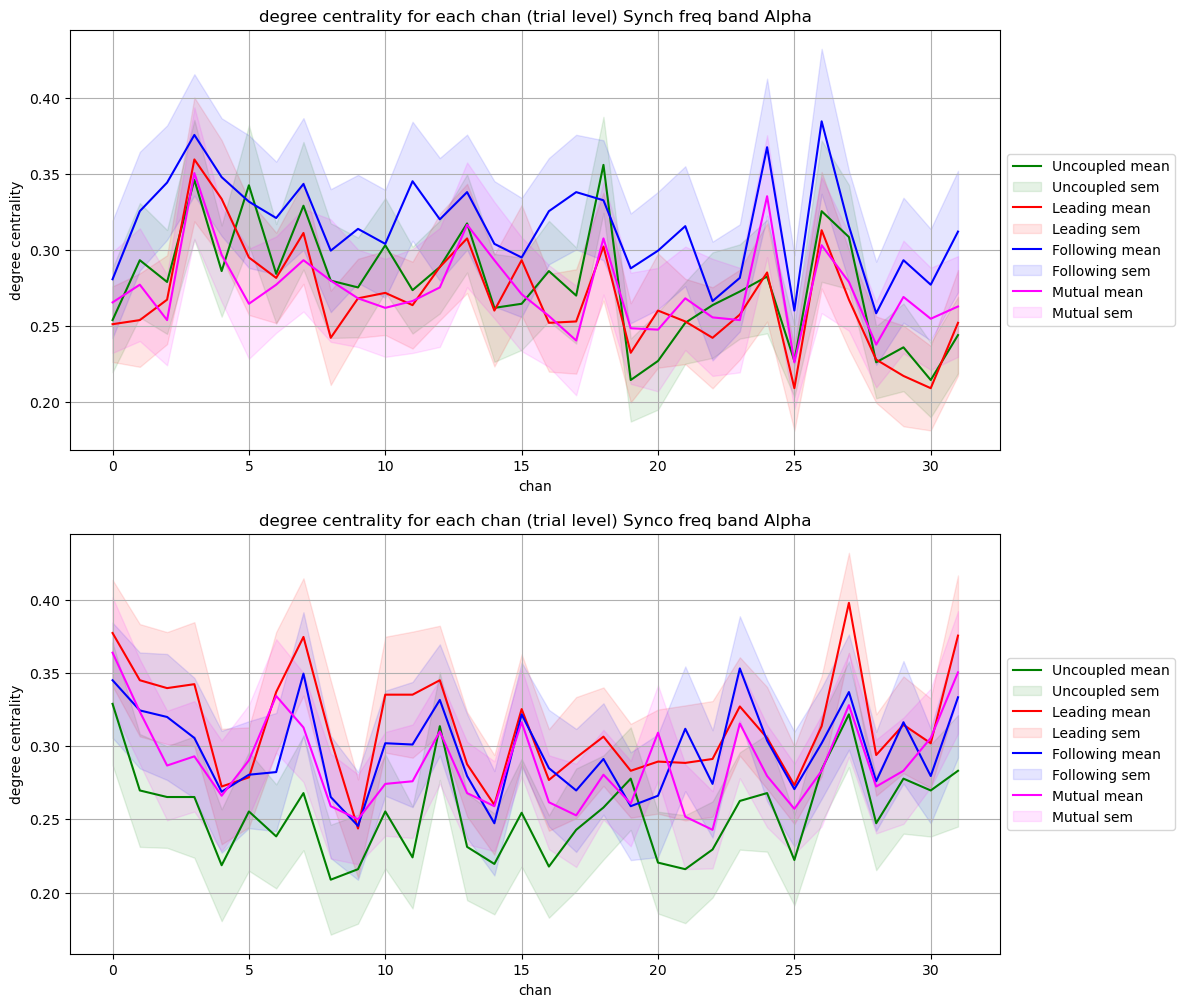

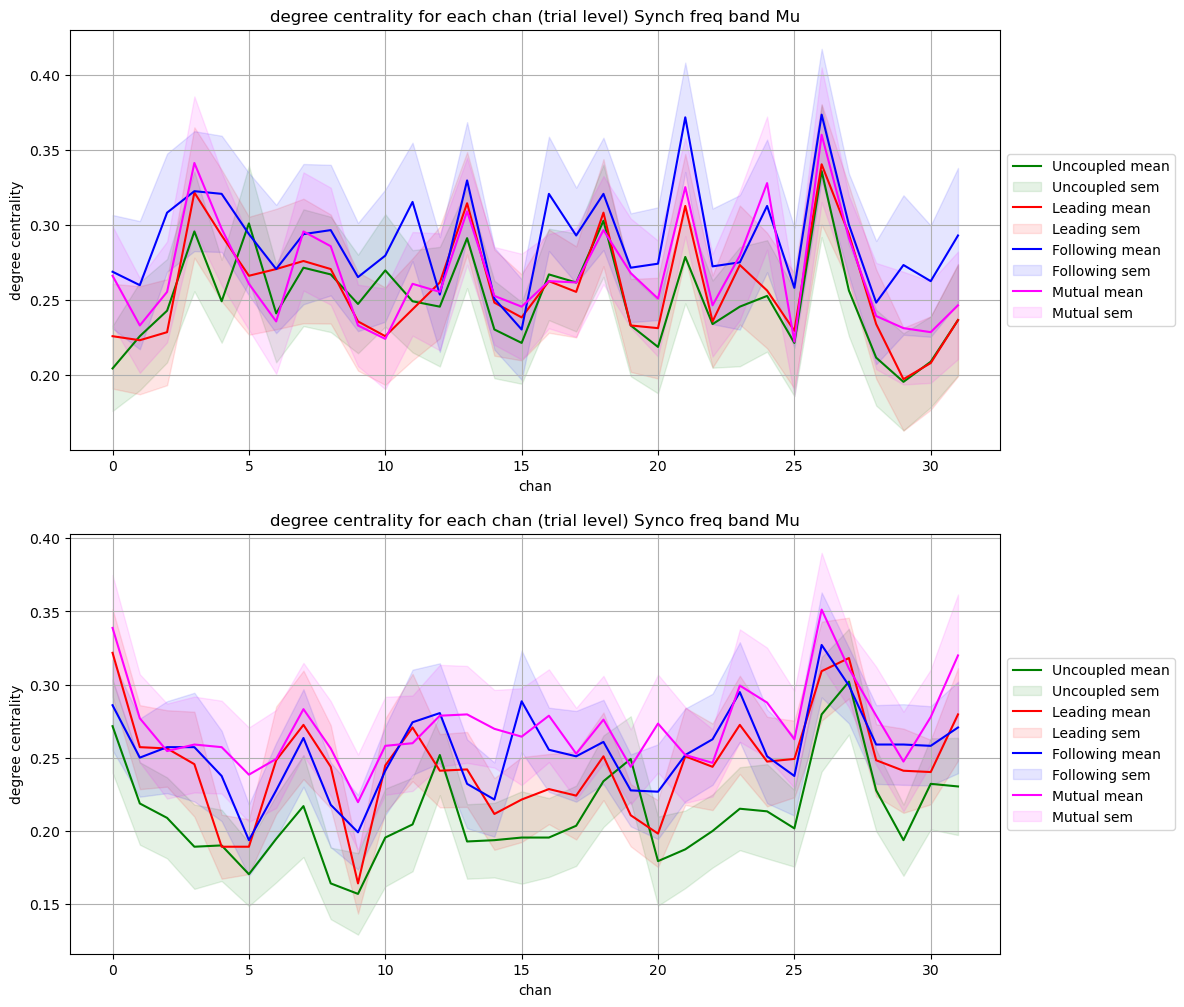

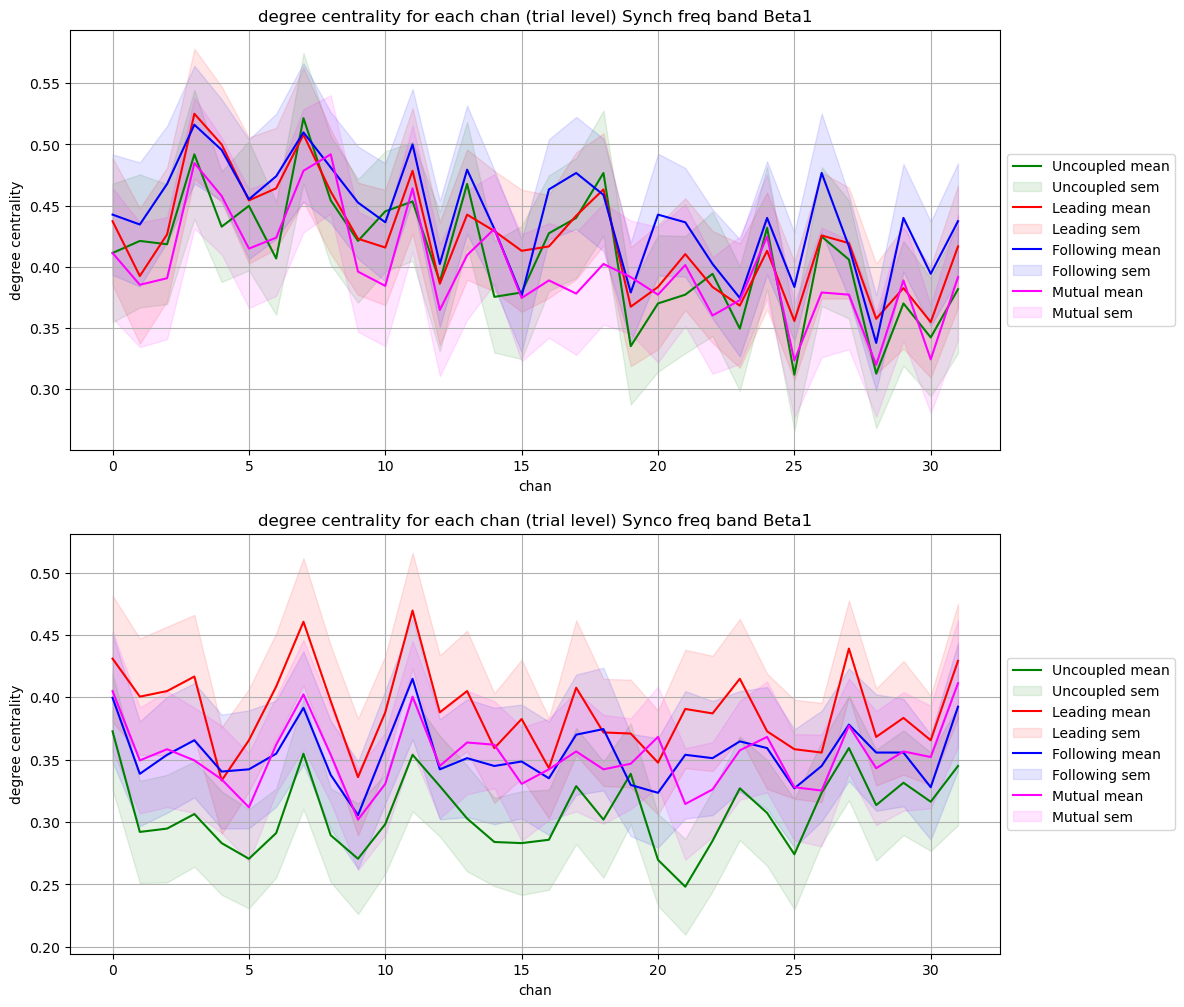

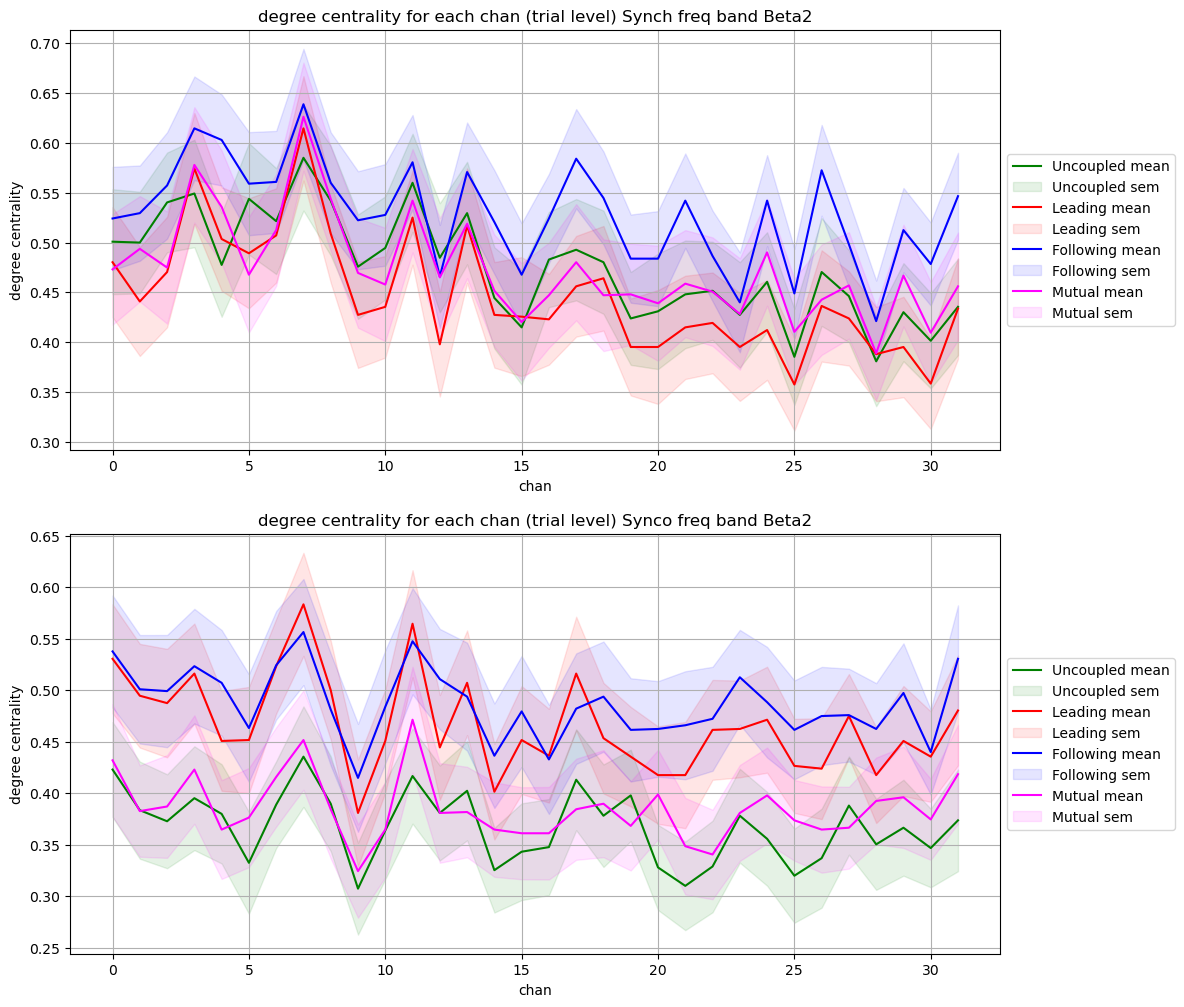

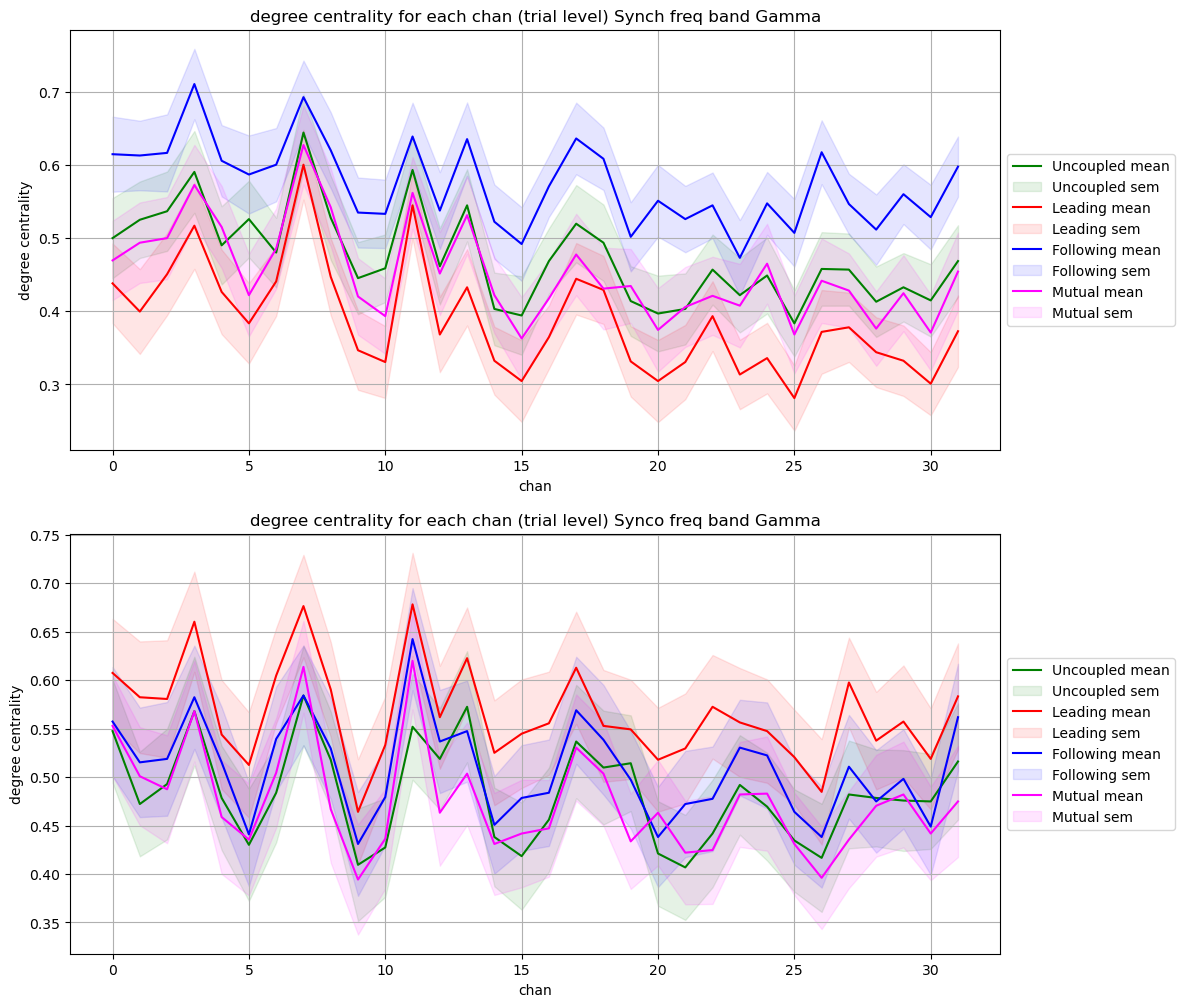

In [16]:
# plot mean centrality with sem
color_4st=['green','red','blue','black']
for freq in range(7):
    fig, ax = plt.subplots(2,1,figsize=(6*2, 6*2))
    for syn in range(2):
        plt.sca(ax[syn])
        for st in range(4):
            plt.plot (np.arange(32),eeg_pcorr_dgctr_mean2x4x7x32[syn,st,freq,:],color=condicolors[st])
            plt.fill_between(np.arange(32),eeg_pcorr_dgctr_mean2x4x7x32[syn,st,freq,:]-eeg_pcorr_dgctr_sem2x4x7x32[syn,st,freq,:],\
                            eeg_pcorr_dgctr_mean2x4x7x32[syn,st,freq,:]+eeg_pcorr_dgctr_sem2x4x7x32[syn,st,freq,:],\
                                color=condicolors[st], alpha=.1)

        plt.xlabel("chan")
        plt.ylabel("degree centrality")
        # plt.xlim(198,200)
        # plt.ylim(-0.17,-0.07)


        plt.title('degree centrality for each chan (trial level) '+syn2names[syn]+' freq band '+ band_labels[freq])
        plt.grid()

        plt.legend(['Uncoupled mean', 'Uncoupled sem', 'Leading mean', 'Leading sem',
            'Following mean', 'Following sem','Mutual mean','Mutual sem'],ncol=1,
            loc='center left', bbox_to_anchor=(1, 0.5))

In [17]:
def cal_mean_sem_aggre_chan(mat1,mat2):
    # this function aggregate the mean and se for all 32 chan
    trl_ctr=np.concatenate((mat1,mat2),axis=0)
    mean_trl_ctr=np.mean(trl_ctr)
    sem_trl_ctr=sem(trl_ctr,axis=None)
    return mean_trl_ctr, sem_trl_ctr

In [21]:
# organze eeg_pcorr_dgctr into 2x4x7x32 # ((144,2,7,32)) # degree centrality (does not account for weight)

# mean and sem of degree centralities in 32 channels  
eeg_pcorr_dgctr # 144x2x7x32
eeg_pcorr_dgctr_mean2x4x7=np.zeros((2,4,7)) # 2 syn types x 4 condi x 7 freq 
eeg_pcorr_dgctr_sem2x4x7=np.zeros((2,4,7)) # 2 syn types x 4 condi x 7 freq 

for syn in range(2):
    for freq in range(7):
        # Uncoupled
        mat1=eeg_pcorr_dgctr[syn2_condi4_ind[syn][0],0,freq,:]
        mat2=eeg_pcorr_dgctr[syn2_condi4_ind[syn][0],1,freq,:]
        eeg_pcorr_dgctr_mean2x4x7[syn,0,freq],eeg_pcorr_dgctr_sem2x4x7[syn,0,freq]=cal_mean_sem_aggre_chan(mat1,mat2)


        # Leading for L&R
        mat1=eeg_pcorr_dgctr[syn2_condi4_ind[syn][1],0,freq,:]
        mat2=eeg_pcorr_dgctr[syn2_condi4_ind[syn][2],1,freq,:]
        eeg_pcorr_dgctr_mean2x4x7[syn,1,freq],eeg_pcorr_dgctr_sem2x4x7[syn,1,freq]=cal_mean_sem_aggre_chan(mat1,mat2)

        # Following for L&R
        mat1=eeg_pcorr_dgctr[syn2_condi4_ind[syn][1],1,freq,:]
        mat2=eeg_pcorr_dgctr[syn2_condi4_ind[syn][2],0,freq,:]
        eeg_pcorr_dgctr_mean2x4x7[syn,2,freq],eeg_pcorr_dgctr_sem2x4x7[syn,2,freq]=cal_mean_sem_aggre_chan(mat1,mat2)

        # Mutual
        mat1=eeg_pcorr_dgctr[syn2_condi4_ind[syn][3],0,freq,:]
        mat2=eeg_pcorr_dgctr[syn2_condi4_ind[syn][3],1,freq,:]
        eeg_pcorr_dgctr_mean2x4x7[syn,3,freq],eeg_pcorr_dgctr_sem2x4x7[syn,3,freq]=cal_mean_sem_aggre_chan(mat1,mat2)


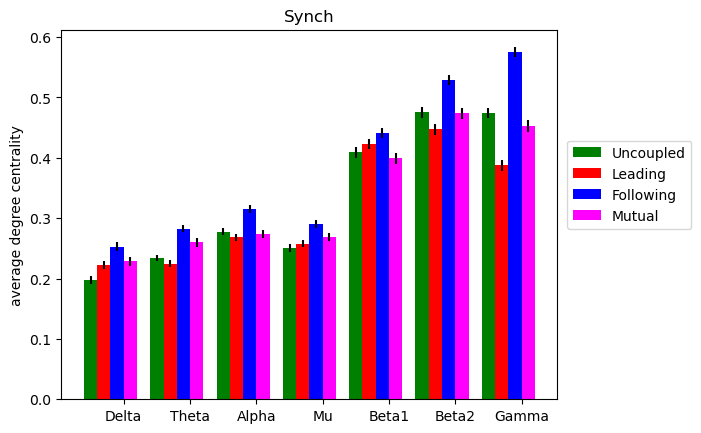

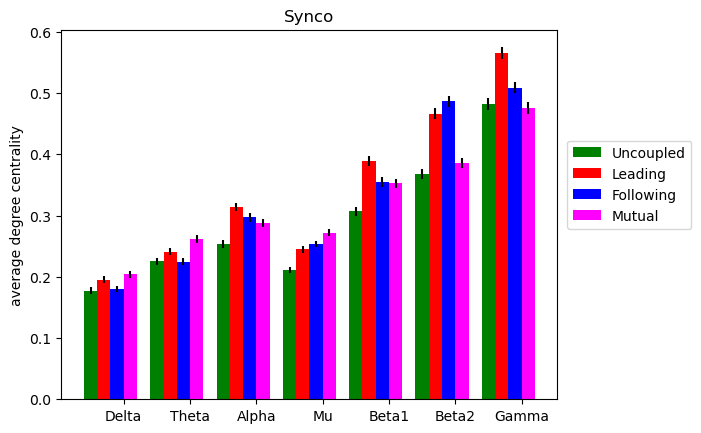

In [22]:
ind = np.arange(7)  # the x locations for the groups
width = 0.2  # the width of the bars

for syn in range(2):
    fig, ax = plt.subplots()
    for st in range(4):
        rects0 = ax.bar(ind + width*st, eeg_pcorr_dgctr_mean2x4x7[syn,st,:], width, yerr=eeg_pcorr_dgctr_sem2x4x7[syn,st,:],
                    label=states4names[st],color=condicolors[st])
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('average degree centrality')
    ax.set_title(syn2names[syn])
    ax.set_xticks(ind+0.5)
    ax.set_xticklabels((band_labels))
    ax.legend(bbox_to_anchor=(1.02, 0.7), loc='upper left', borderaxespad=0)


In [ ]:
# compute mean pcorr in 32x32 mat
eeg_partial_correlation144x2 # 144x2x7x32x32
eeg_pcorr_mean2x4x7=np.zeros((2,4,7,32,32)) # 2 syn types x 4 condi x 7 freq x 32 chan

for freq in range(7):
    # Uncoupled
    eeg_pcorr_mean2x4x7[0,0,freq,:,:]=np.mean(np.concatenate((eeg_partial_correlation144x2[Uncoupled_synch_ind,0,freq,:,:], \
                                            eeg_partial_correlation144x2[Uncoupled_synch_ind,1,freq,:,:]),axis=0),axis=0)
    eeg_pcorr_mean2x4x7[1,0,freq,:,:]=np.mean(np.concatenate((eeg_partial_correlation144x2[Uncoupled_synco_ind,0,freq,:,:], \
                                            eeg_partial_correlation144x2[Uncoupled_synco_ind,1,freq,:,:]),axis=0),axis=0)

    # Leading for L&R
    eeg_pcorr_mean2x4x7[0,1,freq,:,:]=np.mean(np.concatenate((eeg_partial_correlation144x2[L_lead_synch_ind,0,freq,:,:],\
                                            eeg_partial_correlation144x2[R_lead_synch_ind,1,freq,:,:]),axis=0),axis=0)
    eeg_pcorr_mean2x4x7[1,1,freq,:,:]=np.mean(np.concatenate((eeg_partial_correlation144x2[L_lead_synco_ind,0,freq,:,:],\
                                            eeg_partial_correlation144x2[R_lead_synco_ind,1,freq,:,:]),axis=0),axis=0)

    # Following for L&R
    eeg_pcorr_mean2x4x7[0,2,freq,:,:]=np.mean(np.concatenate((eeg_partial_correlation144x2[L_lead_synch_ind,1,freq,:,:],\
                                            eeg_partial_correlation144x2[R_lead_synch_ind,0,freq,:,:]),axis=0),axis=0)
    eeg_pcorr_mean2x4x7[1,2,freq,:,:]=np.mean(np.concatenate((eeg_partial_correlation144x2[L_lead_synco_ind,1,freq,:,:],\
                                            eeg_partial_correlation144x2[R_lead_synco_ind,0,freq,:,:]),axis=0),axis=0)

    # Mutual
    eeg_pcorr_mean2x4x7[0,3,freq,:,:]=np.mean(np.concatenate((eeg_partial_correlation144x2[Mutual_synch_ind,0,freq,:,:], \
                                            eeg_partial_correlation144x2[Mutual_synch_ind,1,freq,:,:]),axis=0),axis=0)
    eeg_pcorr_mean2x4x7[1,3,freq,:,:]=np.mean(np.concatenate((eeg_partial_correlation144x2[Mutual_synco_ind,0,freq,:,:], \
                                            eeg_partial_correlation144x2[Mutual_synco_ind,1,freq,:,:]),axis=0),axis=0)

